In [1]:
#Basic libraries
import urllib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime as dt
from matplotlib.ticker import MaxNLocator
import PIL
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

In [2]:
#Load Data
full_df = pd.read_csv('../road_to_qatar_2022/data/fulldataset.csv')
full_df

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points
0,1930-07-13,France,Mexico,4.0,1.0,,4,1759.78,1764.85,13,1644.89,1649.57
1,1930-07-13,USA,Belgium,3.0,0.0,,16,1627.48,1635.01,2,1816.71,1821.92
2,1930-07-14,Yugoslavia,Brazil,2.0,1.0,,6,64.00,64.00,1,1841.30,1837.56
3,1930-07-14,Romania,Peru,3.0,1.0,,53,1434.68,1427.84,23,1561.01,1562.24
4,1930-07-15,Argentina,France,1.0,0.0,,3,1773.88,1770.65,4,1759.78,1764.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24


In [3]:
#ADD winner column on dataset 
winner = []
for i in range (len(full_df['home_team'])):
    if full_df ['home_score'][i] > full_df['away_score'][i]:
        winner.append('win')
    elif full_df['home_score'][i] < full_df ['away_score'][i]:
        winner.append('lose')
    else:
        winner.append('Draw')
full_df['home_team_result'] = winner

In [4]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'win_conditions', 'home_team_rank', 'home_team_points',
       'home_team_previous_points', 'away_team_rank', 'away_team_points',
       'away_team_previous_points', 'home_team_result'],
      dtype='object')

In [5]:
fifa_rank = full_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = fifa_rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = fifa_rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
fifa_rank = pd.concat([home,away])
#Select each country latest match
fifa_rank = fifa_rank.sort_values(['team','date'],ascending=[True,False])
fifa_rank_top10 = fifa_rank.groupby('team').first().sort_values('rank',ascending=True)[0:11].reset_index()
fifa_rank_top10 = fifa_rank_top10[fifa_rank_top10.team != 'Yugoslavia']#remove this team as his rank is 6, it's unrealistic

# Small Analysis

In [6]:
fifa_rank_top10 = fifa_rank_top10.drop(['date'],axis=1)

In [7]:
fifa_rank_top10

,team,rank
0,Brazil,1
1,Belgium,2
2,Argentina,3
3,France,4
4,England,5
6,Italy,6
7,Spain,7
8,Netherlands,8
9,Portugal,9
10,Denmark,10


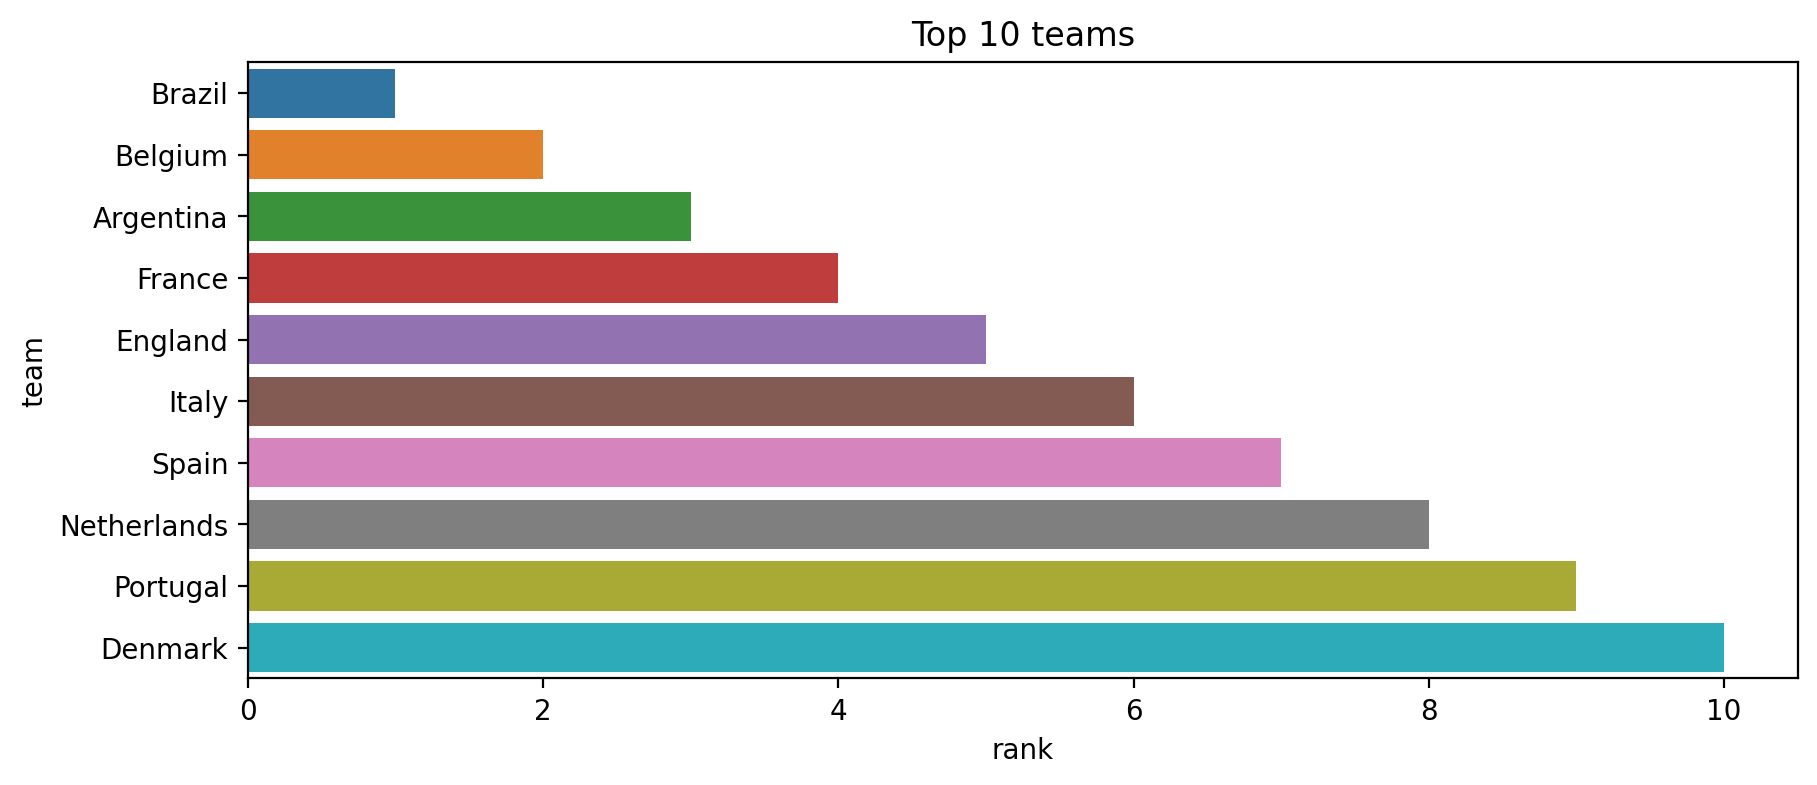

In [8]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(data=fifa_rank_top10,y='team',x='rank')
plt.title("Top 10 teams");

In [9]:
#function calculating average win
def home_percentage(team):
    score = len(full_df[(full_df['home_team'] == team) & (full_df['home_team_result'] == "win")]) / len(full_df[full_df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(full_df[(full_df['away_team'] == team) & (full_df['home_team_result'] == "lose")]) / len(full_df[full_df['away_team'] == team]) * 100
    return round(score)

In [10]:
#add column average win
fifa_rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Average_win_Per'] = round((fifa_rank_top10['Home_win_Per'] + fifa_rank_top10['Away_win_Per'])/2)
fifa_rank_win = fifa_rank_top10.sort_values('Average_win_Per',ascending=False)
fifa_rank_win

,team,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,1,67,39,53.0
8,Netherlands,8,53,42,48.0
6,Italy,6,66,22,44.0
7,Spain,7,50,37,44.0
3,France,4,54,31,42.0
2,Argentina,3,67,9,38.0
1,Belgium,2,58,16,37.0
9,Portugal,9,63,9,36.0
10,Denmark,10,33,38,36.0
4,England,5,56,13,34.0


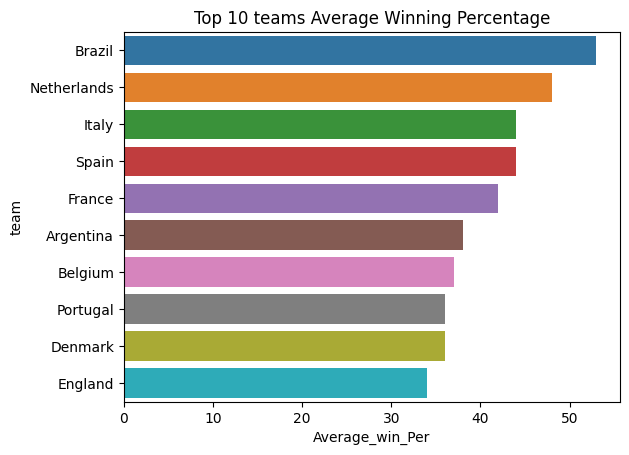

In [11]:
#data viz for top 10 teams
sns.barplot(data=fifa_rank_win,x='Average_win_Per',y='team')
plt.title("Top 10 teams Average Winning Percentage");

In [12]:
full_df.tail()

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points,home_team_result
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64,Draw
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,Draw
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,win
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24,Draw
1030,2022-06-14,Chile,Ghana,0.0,0.0,Ghana,29,1509.61,1514.86,61,1393.00,1393.47,Draw


In [13]:
#Filter the teams participating in World cup 22
list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']
final_df = full_df[(full_df["home_team"].apply(lambda x: x in list_2022)) | (full_df["away_team"].apply(lambda x: x in list_2022))]


In [14]:
#filter latest ranking 
rank = final_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
rank = pd.concat([home,away])
#Select each country latest match
rank = rank.sort_values(['team','date'],ascending=[True,False])
rank_top10 = rank.groupby('team').first().sort_values('rank',ascending=True).reset_index()
rank_top10 = rank_top10[(rank_top10["team"].apply(lambda x: x in list_2022))][0:10]
rank_top10.drop(['date'],axis=1)

,team,rank
0,Brazil,1
1,Belgium,2
2,Argentina,3
3,France,4
4,England,5
7,Spain,7
8,Netherlands,8
9,Portugal,9
10,Denmark,10
11,Germany,11


In [15]:
#updated average win
rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(rank_top10['team'])
rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(rank_top10['team'])
rank_top10['Average_win_Per'] = round((rank_top10['Home_win_Per'] + rank_top10['Away_win_Per'])/2)
rank_top10_Win = rank_top10.sort_values('Average_win_Per',ascending=False)
rank_top10_Win


,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
11,Germany,2016-07-02,11,67,49,58.0
0,Brazil,2019-06-27,1,67,39,53.0
8,Netherlands,2014-07-12,8,53,42,48.0
7,Spain,2021-07-06,7,50,37,44.0
3,France,2021-06-28,4,54,31,42.0
2,Argentina,2021-07-06,3,67,9,38.0
1,Belgium,2014-07-05,2,58,16,37.0
9,Portugal,2017-06-28,9,63,9,36.0
10,Denmark,2018-07-01,10,33,38,36.0
4,England,2021-07-11,5,56,13,34.0


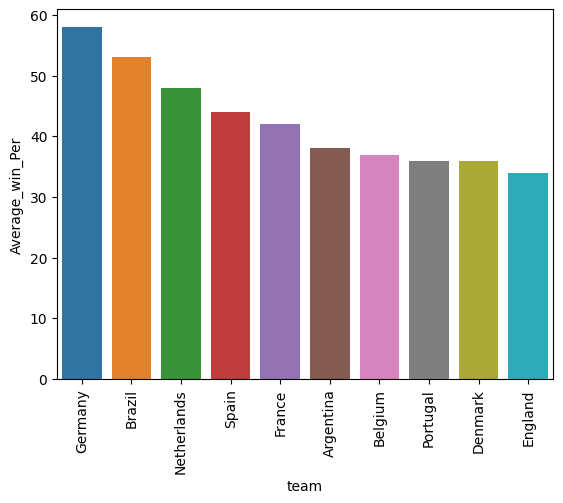

In [16]:
#data viz for average win
sns.barplot(data=rank_top10_Win,x='team',y='Average_win_Per')
plt.xticks(rotation=90);

In [17]:
#Mapping numeric values for home_team_result to find the correleations
#win = 1
#Draw = 2
#lose = 0
final_df['home_team_result'] = final_df['home_team_result'].map({'win':1, 'Draw':2, 'lose':0})

/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_59104/1821822757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['home_team_result'] = final_df['home_team_result'].map({'win':1, 'Draw':2, 'lose':0})


In [18]:
final_df.corr()['home_team_result'].sort_values(ascending=False)

/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_59104/4154585168.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df.corr()['home_team_result'].sort_values(ascending=False)


home_team_result             1.000000
away_team_rank               0.141939
home_team_rank               0.053119
home_team_points             0.002057
home_team_previous_points    0.001444
away_team_points            -0.069523
away_team_previous_points   -0.069665
home_score                  -0.083079
away_score                  -0.385247
Name: home_team_result, dtype: float64

In [19]:
final_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'win_conditions', 'home_team_rank', 'home_team_points',
       'home_team_previous_points', 'away_team_rank', 'away_team_points',
       'away_team_previous_points', 'home_team_result'],
      dtype='object')

In [20]:
final_df =final_df.drop(['date','win_conditions','home_team_previous_points','away_team_points'], axis=1)

In [21]:
final_df.tail()

,home_team,away_team,home_score,away_score,home_team_rank,home_team_points,away_team_rank,away_team_previous_points,home_team_result
1026,Cameroon,Burkina Faso,3.0,3.0,43,1471.44,54,1425.64,2
1027,Senegal,Egypt,0.0,0.0,18,1584.38,39,1482.63,2
1028,Senegal,Egypt,1.0,0.0,18,1584.38,39,1482.63,1
1029,Australia,Peru,0.0,0.0,38,1488.72,23,1562.24,2
1030,Chile,Ghana,0.0,0.0,29,1509.61,61,1393.47,2


/var/folders/3k/6s7zxjhs2yl_vx0_gr_h6ck80000gn/T/ipykernel_59104/1269800436.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_df.corr(),annot=True)


<AxesSubplot: >

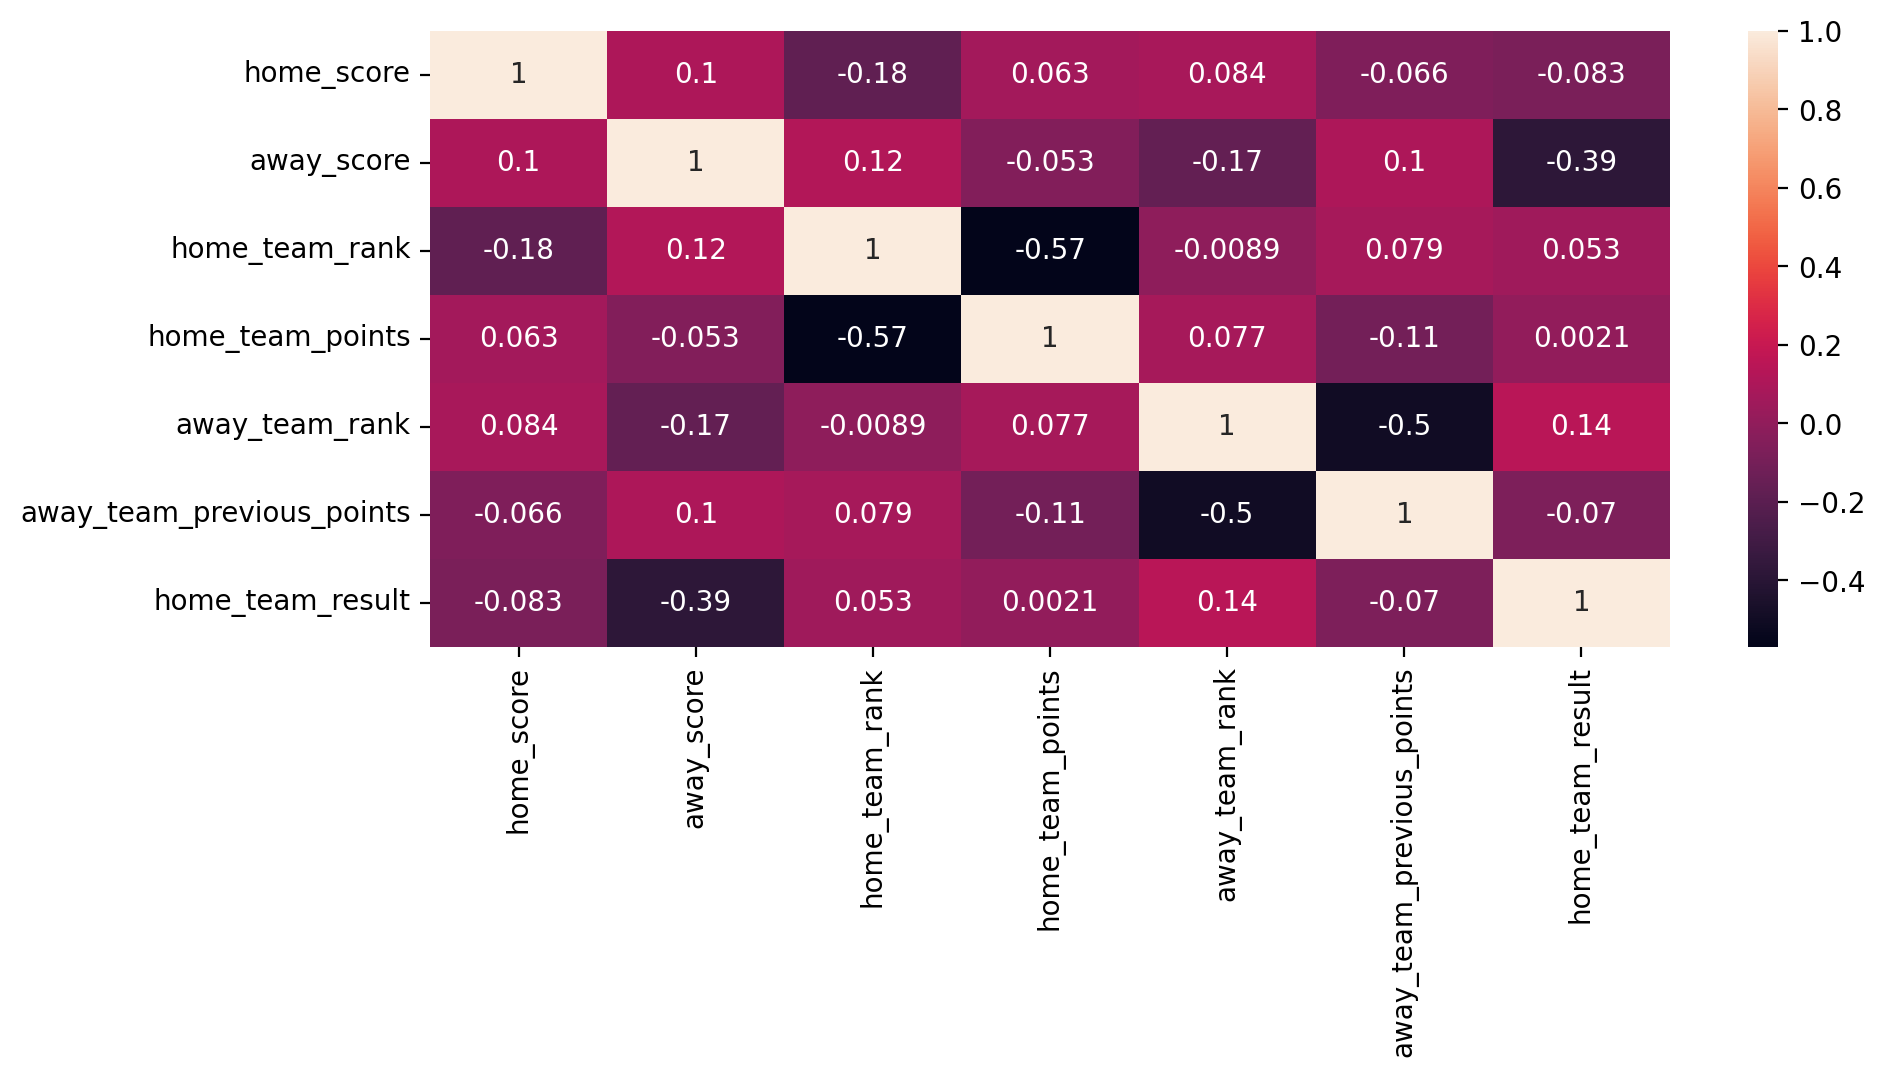

In [22]:
plt.figure(figsize=(10,4),dpi=200)
sns.heatmap(final_df.corr(),annot=True)

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 1030
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   home_team                  884 non-null    object 
 1   away_team                  884 non-null    object 
 2   home_score                 884 non-null    float64
 3   away_score                 884 non-null    float64
 4   home_team_rank             884 non-null    int64  
 5   home_team_points           884 non-null    float64
 6   away_team_rank             884 non-null    int64  
 7   away_team_previous_points  884 non-null    float64
 8   home_team_result           884 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 69.1+ KB


In [24]:
#Holdout another DF for pipeline
pipe_DF = final_df
#Create dummies for categorical columns
final_df = pd.get_dummies(final_df)

# Prediction models for preliminary round - W,D,L

In [25]:
#split X and y and train test split (For League Matches)
X = final_df.drop('home_team_result',axis=1)
y = final_df['home_team_result']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
#Validtion and test set
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [26]:
#Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold_test = scaler.transform(X_hold_test)


In [27]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
#function to fit different model and vizualize them
def metrics_display(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       1.00      1.00      1.00        58
           2       0.98      1.00      0.99        46

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



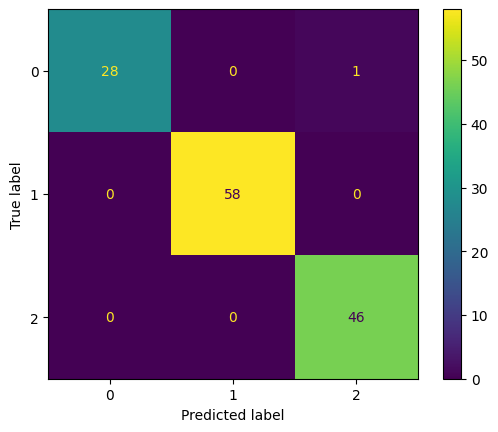

In [28]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       1.00      0.69      0.82        29
           1       0.82      0.84      0.83        58
           2       0.72      0.83      0.77        46

    accuracy                           0.80       133
   macro avg       0.84      0.79      0.80       133
weighted avg       0.82      0.80      0.81       133



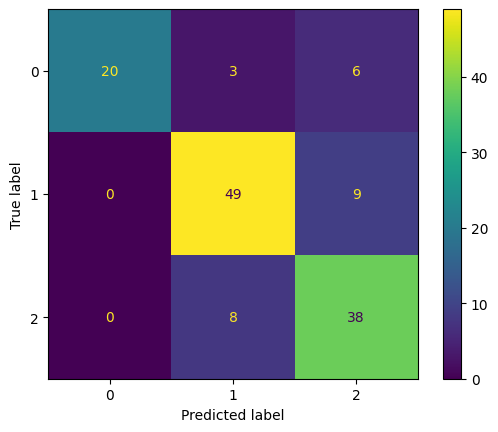

In [29]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
metrics_display(RandomForestClassifier())

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        29
           1       1.00      0.64      0.78        58
           2       0.55      1.00      0.71        46

    accuracy                           0.72       133
   macro avg       0.85      0.70      0.70       133
weighted avg       0.85      0.72      0.72       133



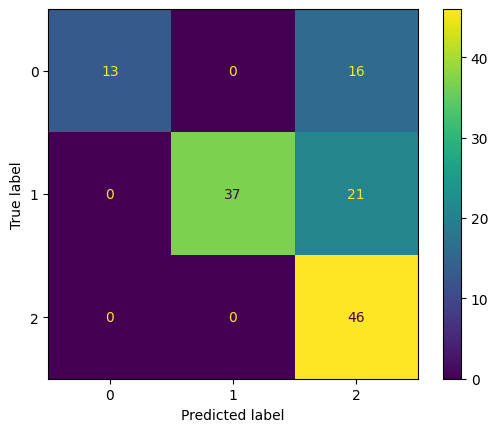

In [30]:
#Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
metrics_display(AdaBoostClassifier())


/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       1.00      1.00      1.00        58
           2       0.98      1.00      0.99        46

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



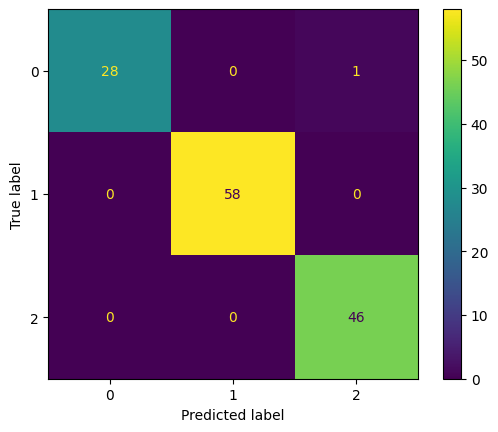

In [31]:

#XGB Boost
from xgboost import XGBClassifier
metrics_display(XGBClassifier(use_label_encoder=False))

In [32]:
X_train.shape


(618, 182)

In [ ]:
#simple Neural network
#p.s : can't run it on my machine because of the tensorflow package conflicts with M1, try to run and see the results
import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from keras import Input

model = Sequential()
model.add(Input(shape=(182,)))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10,validation_split=0.2)

y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1,axis=1)
print(classification_report(y_test,y_pred1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.99      1.00      0.99        67
           2       1.00      0.98      0.99        44

    accuracy                           0.99       133
   macro avg       1.00      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



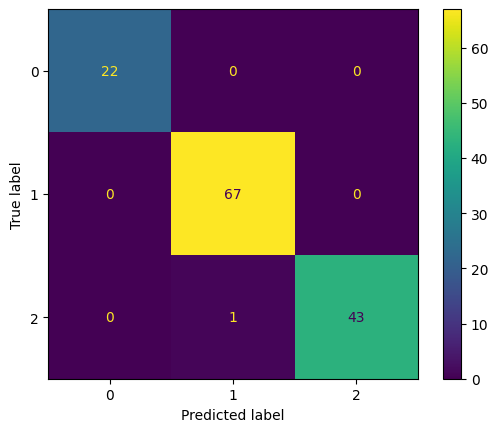

In [33]:
#Checking the final score on testing the holdout test in XGB
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

In [35]:
#XGB Model is finalised, so creating a pipeline for the prelim
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(),['home_team', 'away_team']),remainder='passthrough')

pipe_X = pipe_DF.drop('home_team_result',axis=1)
pipe_y = pipe_DF['home_team_result']

from sklearn.pipeline import make_pipeline
pipe_League = make_pipeline(column_trans,StandardScaler(with_mean=False),XGBClassifier(use_label_encoder=False))
pipe_League.fit(pipe_X,pipe_y)


/Users/prashaantgaju/.pyenv/versions/3.8.12/envs/RoadToQatar2022/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['home_team',
                                                   'away_team'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_s...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [ ]:
#Dumping the pipeline model
import joblib
#joblib.dump(pipe_League,"League_Predictions.pkl")

# Prediction for Knockout Stage  - Removing Draw Status

In [46]:
#removing draw results (draw == 2)
knock_df = pipe_DF[pipe_DF['home_team_result'] != 2]

In [48]:
pipe_knock_df = knock_df
knock_df = pd.get_dummies(knock_df)
X = knock_df.drop('home_team_result',axis=1)
y = knock_df['home_team_result']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.96      1.00      0.98        65

    accuracy                           0.97        86
   macro avg       0.98      0.93      0.95        86
weighted avg       0.97      0.97      0.96        86



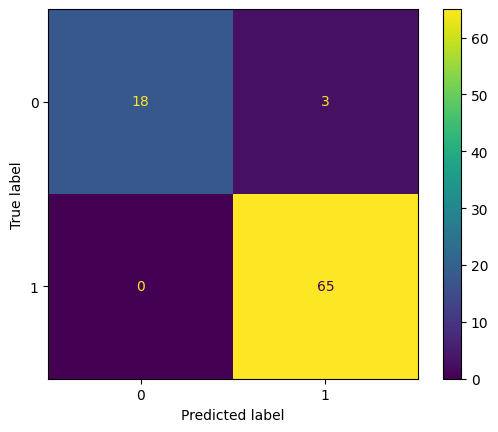

In [49]:
metrics_display(RandomForestClassifier())

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.97      1.00      0.98        62

    accuracy                           0.98        86
   macro avg       0.98      0.96      0.97        86
weighted avg       0.98      0.98      0.98        86



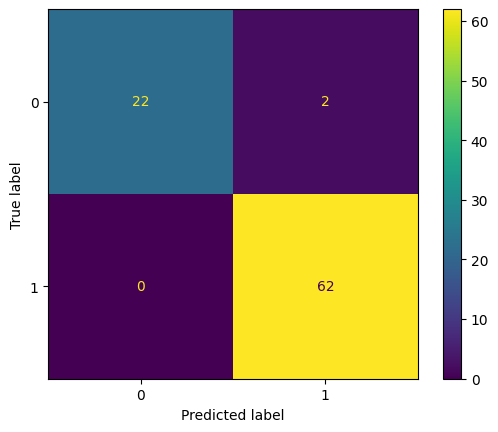

In [50]:
#Random Forest is giving good accuracy, so testing with holdout test and finalising the model
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);


In [51]:
#Building pipeline for knockout round
pipe_X = pipe_knock_df.drop('home_team_result',axis=1)
pipe_y = pipe_knock_df['home_team_result']
column_trans = make_column_transformer(
    (OneHotEncoder(),['home_team', 'away_team']),remainder='passthrough')
pipe_knock = make_pipeline(column_trans,StandardScaler(with_mean=False),RandomForestClassifier())
pipe_knock.fit(pipe_X,pipe_y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['home_team',
                                                   'away_team'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
#joblib.dump(pipe_knock,"KnockOut_Predictions.pkl")